In [ ]:
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (16, 6)

In [11]:
def load_and_process_data(filepath):
    df = pd.read_csv(filepath)
    df['currenttimestamp'] = pd.to_datetime(df['currenttimestamp'], format='mixed')
    df = df.sort_values('currenttimestamp')
    return df

df = load_and_process_data('data/data.csv')

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 88581 entries, 0 to 88580
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   trade_id          88581 non-null  object        
 1   symbol            88581 non-null  object        
 2   trade_volume      88581 non-null  float64       
 3   currenttimestamp  88581 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 3.4+ MB


,trade_volume,currenttimestamp
count,88581.000000,88581
mean,1059.110249,2025-12-09 16:56:24.897790464
min,1.315500,2025-12-09 00:07:10.005000
25%,27.761850,2025-12-09 11:39:42.302000128
50%,93.662900,2025-12-09 17:51:16.559000064
75%,498.555000,2025-12-09 22:20:20.880000
max,610579.001120,2025-12-10 10:19:00.150000
std,6161.428584,NaN


In [12]:
df['symbol'].value_counts()

symbol_stats = df.groupby('symbol')['trade_volume'].agg(['count', 'mean', 'sum', 'min', 'max'])
symbol_stats

,count,mean,sum,min,max
symbol,,,,,
ETHUSDT,15482,1984.907796,3.073034e+07,30.8916,525002.73800
LINKUSDT,1739,67.987242,1.182298e+05,1.3536,3117.09060
SOLUSDT,7887,1691.942792,1.334435e+07,1.3155,511044.17280
XBTUSDT,56389,762.998059,4.302470e+07,8.9463,610579.00112
XRPUSDT,7084,931.595475,6.599422e+06,2.0408,102552.68830


In [13]:
df['currenttimestamp'] = pd.to_datetime(df['currenttimestamp'], format='mixed')
df = df.sort_values('currenttimestamp')

Text(0, 0.5, 'Trade Volume')

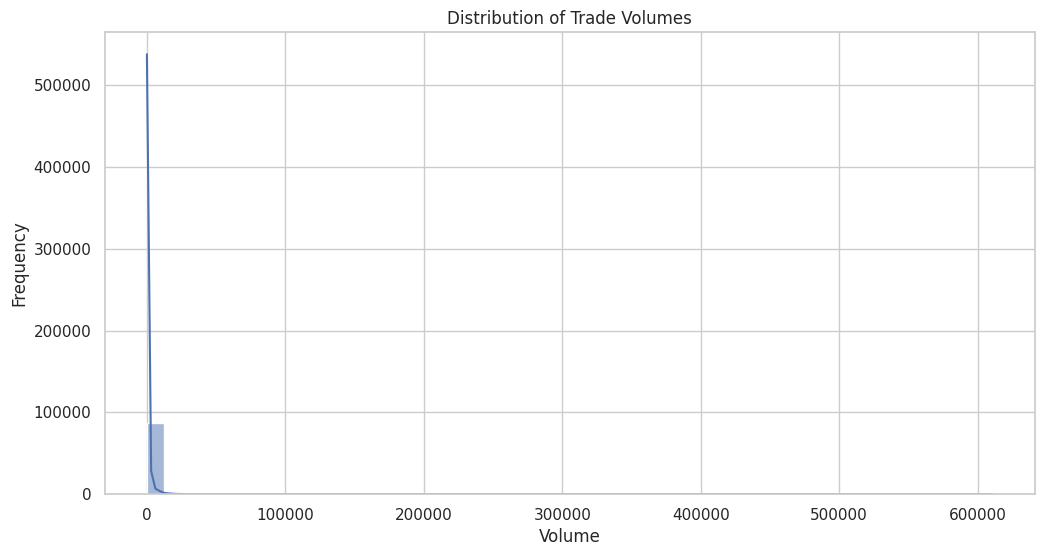

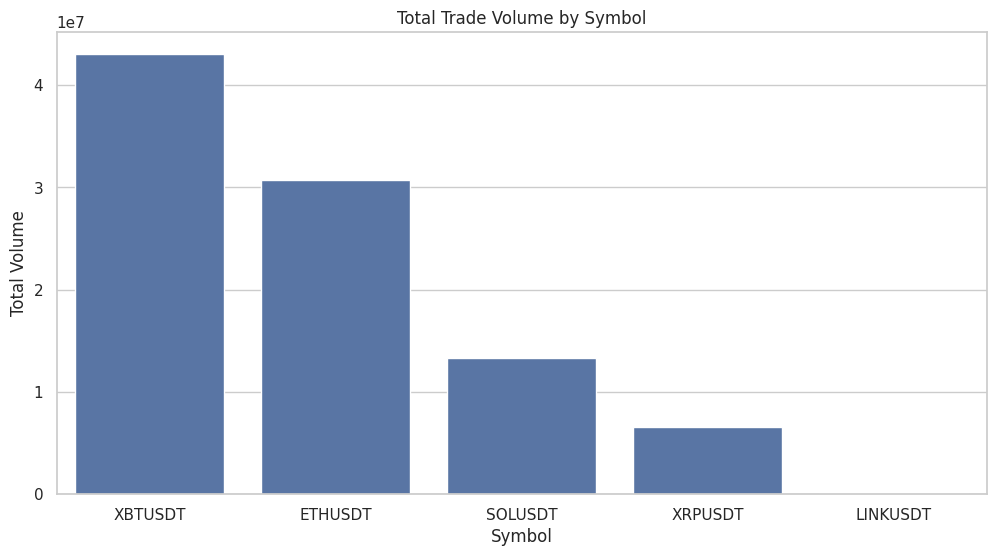

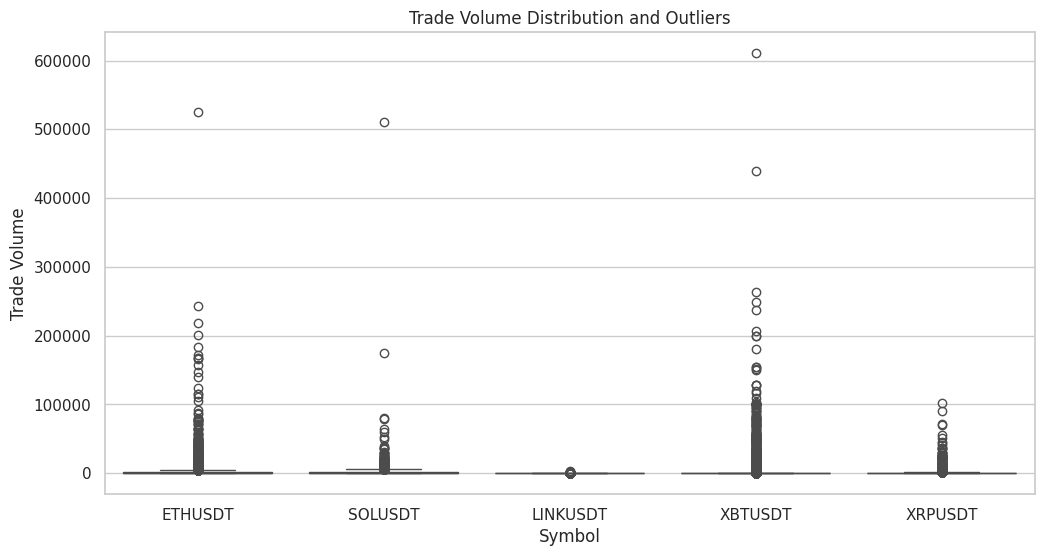

In [14]:
# 1. Distribution of Trade Volumes
plt.figure(figsize=(12, 6))
sns.histplot(df['trade_volume'], bins=50, kde=True)
plt.title('Distribution of Trade Volumes')
plt.xlabel('Volume')
plt.ylabel('Frequency')

# 2. Total Trade Volume by Symbol
plt.figure(figsize=(12, 6))
volume_by_symbol = df.groupby('symbol')['trade_volume'].sum().sort_values(ascending=False)
sns.barplot(x=volume_by_symbol.index, y=volume_by_symbol.values)
plt.title('Total Trade Volume by Symbol')
plt.ylabel('Total Volume')
plt.xlabel('Symbol')


# 3. Trade Volume Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='symbol', y='trade_volume', data=df)
plt.title('Trade Volume Distribution and Outliers')
plt.xlabel('Symbol')
plt.ylabel('Trade Volume')

1. Distribution of Trade Volumes (Histogram)
Interpretation: The highly skewed distribution (long tail to the right) is typical for market data. It indicates that the vast majority of transactions are small (retail/low-frequency traders), while a small number of trades are significantly larger (institutional players or "whales"). This suggests that market liquidity and price movement are predominantly influenced by these large, infrequent transactions.

2. Total Trade Volume by Symbol (Bar Plot)
Interpretation: This chart establishes market share or liquidity dominance. The symbol with the highest bar is the most liquid and actively traded, making it generally safer and easier to execute large orders without significant price impact (lower slippage). Low-volume symbols indicate less interest and potentially higher volatility or wider spreads.

3. Trade Volume Distribution and Outliers (Boxplot)
Interpretation: The position of the box and whiskers shows the "normal" trading range. The isolated points (outliers) represent extremely large trades. A high density of such outliers for a specific symbol confirms sustained activity by large-volume traders, which is a key indicator for monitoring major capital flows.

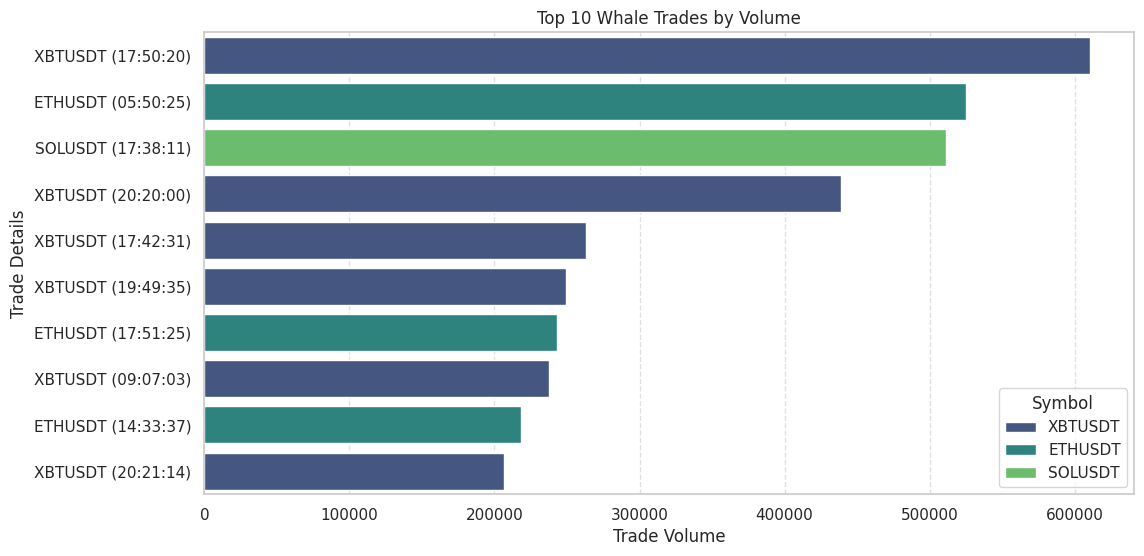

In [15]:
top_trades = df.nlargest(10, 'trade_volume').copy()

top_trades['label'] = top_trades['symbol'] + ' (' + top_trades['currenttimestamp'].dt.strftime('%H:%M:%S') + ')'

plt.figure(figsize=(12, 6))
sns.barplot(data=top_trades, x='trade_volume', y='label', hue='symbol', dodge=False, palette='viridis')

plt.title('Top 10 Whale Trades by Volume')
plt.xlabel('Trade Volume')
plt.ylabel('Trade Details')
plt.legend(title='Symbol')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

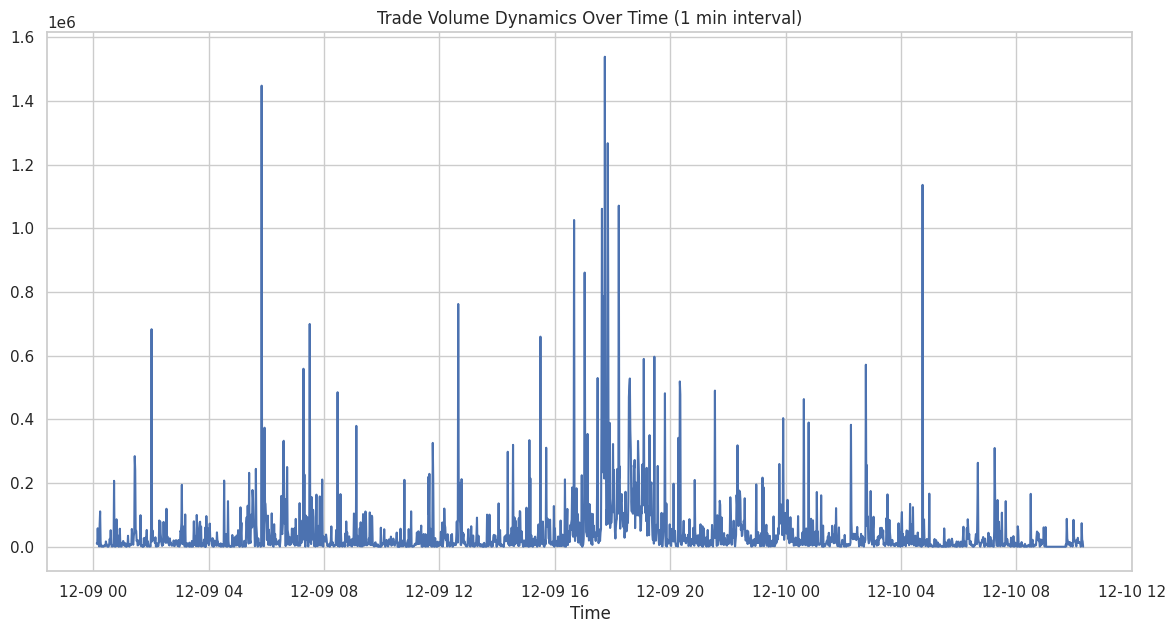

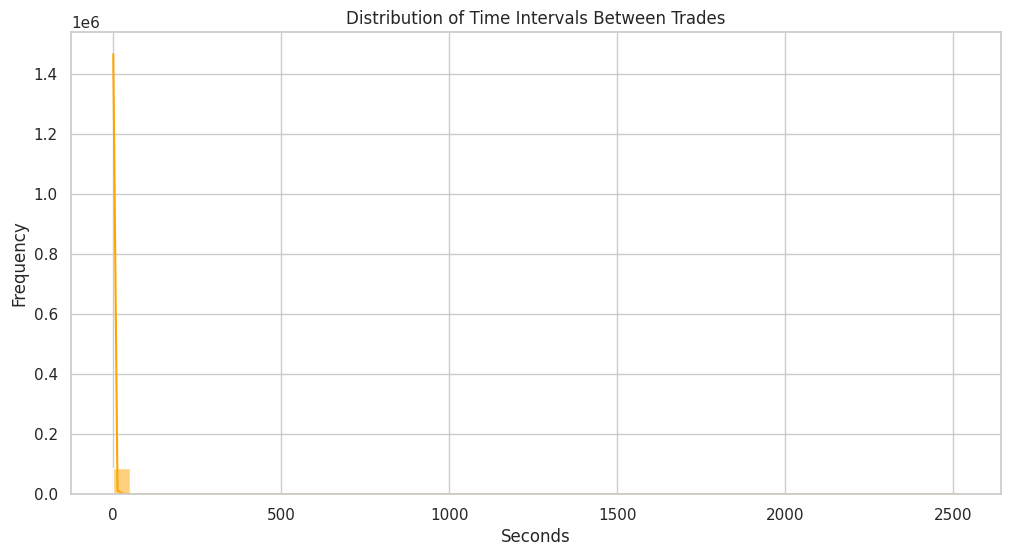

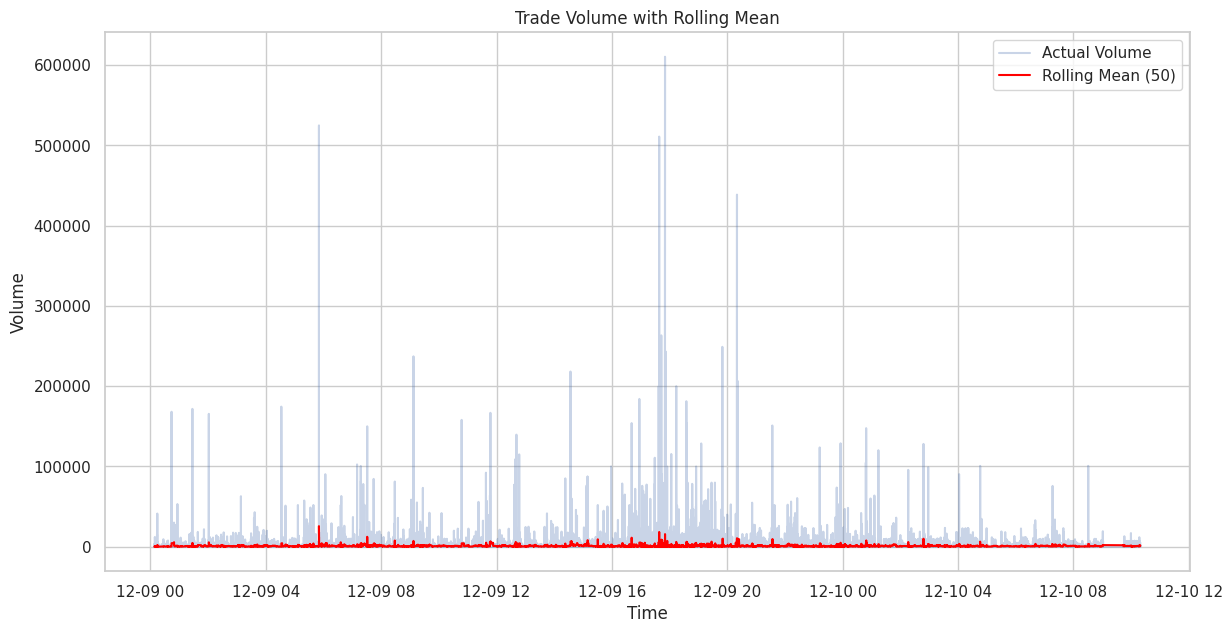

In [16]:
# 4. Trade Volume Dynamics Over Time
df_time = df.set_index('currenttimestamp')
df_resampled = df_time.resample('1min')['trade_volume'].sum()

plt.figure(figsize=(14, 7))
plt.plot(df_resampled.index, df_resampled.values)
plt.title('Trade Volume Dynamics Over Time (1 min interval)')
plt.xlabel('Time')
# 5. Distribution of Time Intervals
df['time_diff'] = df['currenttimestamp'].diff().dt.total_seconds()

plt.figure(figsize=(12, 6))
sns.histplot(df['time_diff'].dropna(), bins=50, kde=True, color='orange')
plt.title('Distribution of Time Intervals Between Trades')
plt.xlabel('Seconds')
plt.ylabel('Frequency')
# 6. Trade Volume with Rolling Mean
df['rolling_mean'] = df['trade_volume'].rolling(window=50).mean()

plt.figure(figsize=(14, 7))
plt.plot(df['currenttimestamp'], df['trade_volume'], label='Actual Volume', alpha=0.3)
plt.plot(df['currenttimestamp'], df['rolling_mean'], label='Rolling Mean (50)', color='red')
plt.title('Trade Volume with Rolling Mean')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.legend()

4. Trade Volume Dynamics Over Time (Time Series, 1 min interval)

Interpretation: This visualization helps identify intraday seasonality and periods of heightened market interest. Sharp, sustained peaks indicate high-activity zones, often corresponding to major market openings (e.g., US/Europe session overlap) or response to fundamental news.

5. Distribution of Time Intervals Between Trades (Histogram)

Interpretation: A strong clustering of intervals close to zero (e.g., under 1 second) is a clear sign of High-Frequency Trading (HFT) or active automated bots. The denser the cluster near zero, the more efficient and fast the market is. Longer intervals suggest market pauses or lack of current liquidity.

6. Trade Volume with Rolling Mean (Time Series)

Interpretation: The raw data is chaotic and full of noise. The Rolling Mean filters out this noise to reveal the underlying trend in market participation. If the red line shows a sustained upward or downward slope, it indicates a fundamental shift in liquidity and activity over time.

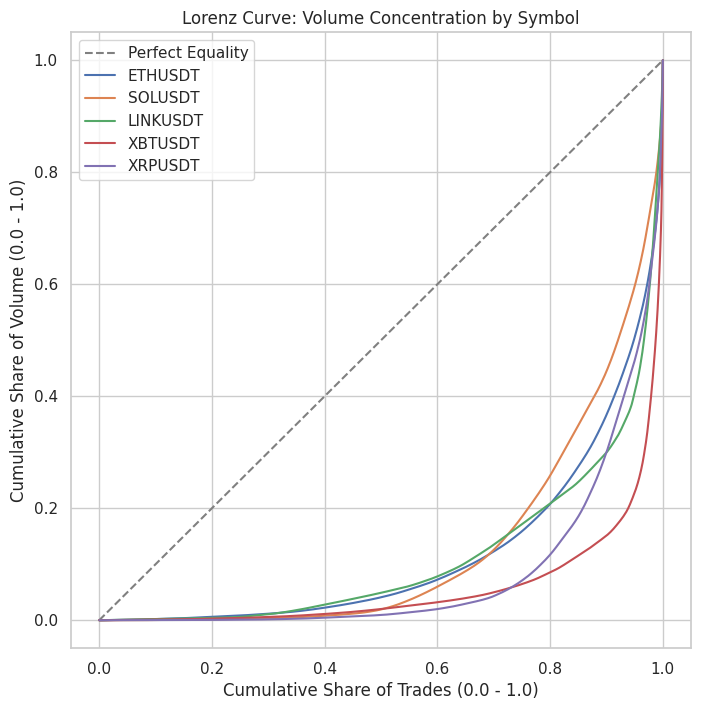

In [17]:
def plot_lorenz_curve(data, label):
    sorted_data = np.sort(data)
    cumulative_data = np.cumsum(sorted_data) / np.sum(sorted_data)
    cumulative_share = np.arange(1, len(cumulative_data) + 1) / len(cumulative_data)
    plt.plot(cumulative_share, cumulative_data, label=label)

plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Perfect Equality')

for symbol in df['symbol'].unique():
    symbol_data = df[df['symbol'] == symbol]['trade_volume'].values
    plot_lorenz_curve(symbol_data, symbol)

plt.title('Lorenz Curve: Volume Concentration by Symbol')
plt.xlabel('Cumulative Share of Trades (0.0 - 1.0)')
plt.ylabel('Cumulative Share of Volume (0.0 - 1.0)')
plt.legend()
plt.show()

--- Pareto Analysis ---
80% об'єму торгів формується лише 10.75% угод.


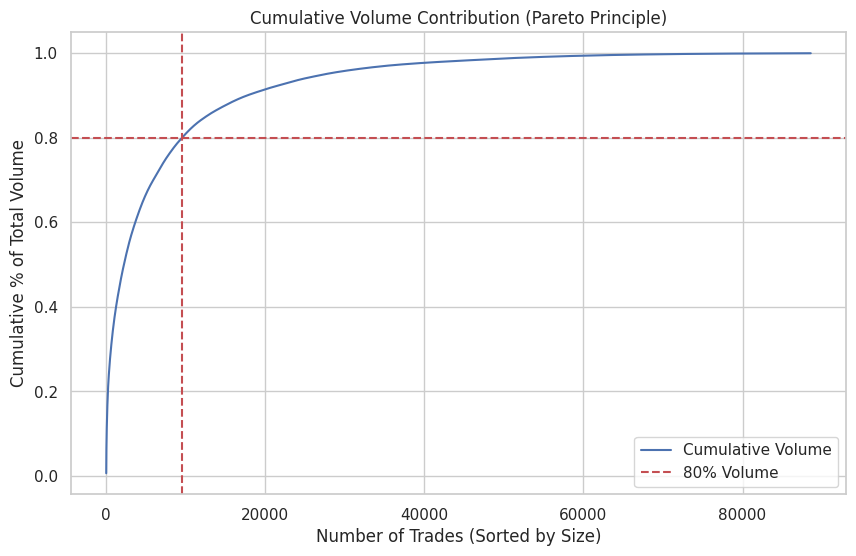

In [18]:
sorted_vols = df['trade_volume'].sort_values(ascending=False).values
total_vol = sorted_vols.sum()
cumulative_vol = sorted_vols.cumsum() / total_vol

pareto_idx = next(x[0] for x in enumerate(cumulative_vol) if x[1] > 0.8)
pareto_percent = (pareto_idx / len(df)) * 100

print(f"--- Pareto Analysis ---")
print(f"80% об'єму торгів формується лише {pareto_percent:.2f}% угод.")

plt.figure(figsize=(10, 6))
plt.plot(range(len(cumulative_vol)), cumulative_vol, label='Cumulative Volume')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Volume')
plt.axvline(x=pareto_idx, color='r', linestyle='--')
plt.title('Cumulative Volume Contribution (Pareto Principle)')
plt.xlabel('Number of Trades (Sorted by Size)')
plt.ylabel('Cumulative % of Total Volume')
plt.legend()
plt.grid(True)
plt.show()

8. Cumulative Volume Contribution (Pareto Analysis)

Interpretation: This analysis quantifies the concentration of risk (Pareto Principle or 80/20 Rule). If the 80% mark is reached by a very small percentage of trades (e.g., 5-10%), it means the market’s liquidity is concentrated in the hands of a few major players. This structure is sensitive to the actions of those large traders.